# Climate change sucks

In [1]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
import pennylane as qml
import tensorflow
from tensorflow import keras

## Read in data

In [2]:
# Initialize empty lists to store data
prev_years = [[],[]]
final_years = [[],[]]

# Load temperature change data
with open('./data/Annual_Surface_Temperature_Change.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temperature_data = [float(val) if val else 0.0 for val in row[35:-1]]
        final_temperature = float(row[-1]) if row[-1] else 0.0
        prev_years[0].append(temperature_data)
        final_years[0].append(final_temperature)

# Load total number of disasters data
with open("./data/disastors.csv", 'r', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t') 

    for row in csvreader:
        if row[4] == 'Total disasters' and row[5] == 'Number of':
            disasters_data = [float(val) if val else 0.0 for val in row[6:-1]]
            final_disasters = float(row[-1]) if row[-1] else 0.0
            prev_years[1].append(disasters_data)
            final_years[1].append(final_disasters)

# Convert the lists to PyTorch tensors
prev_years = torch.tensor(prev_years, dtype=torch.float64)
final_years = torch.tensor(final_years, dtype=torch.float64)

training_data = prev_years[:,:150,:]
test_data = prev_years[:,150:,:]

training_labels = final_years[:,:150]
test_labels = final_years[:,150:]

print("training data    ",training_data.shape)
print("test data        ",test_data.shape)
print("training labels  ",training_labels.shape)
print("test labels      ",test_labels.shape)


training data     torch.Size([2, 150, 30])
test data         torch.Size([2, 50, 30])
training labels   torch.Size([2, 150])
test labels       torch.Size([2, 50])


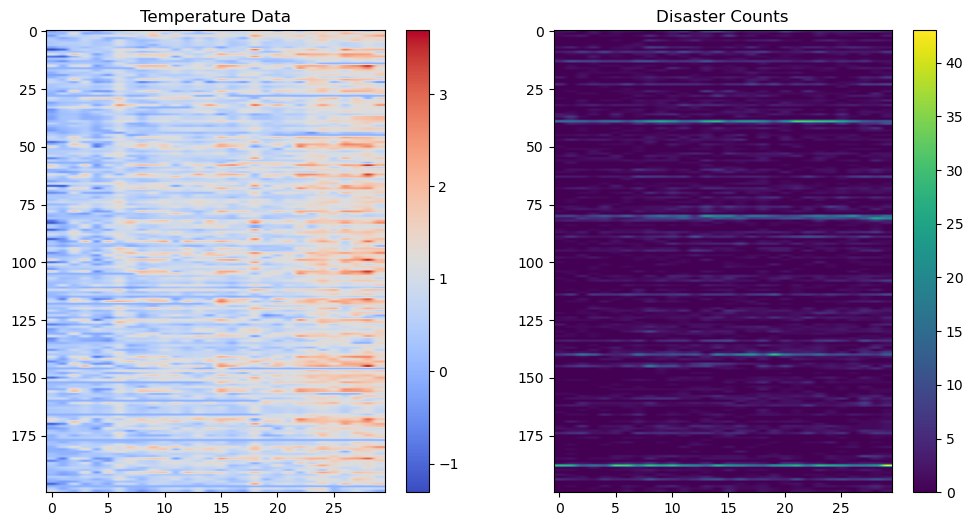

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(prev_years[0], cmap='coolwarm', aspect='auto')
plt.title('Temperature Data')
plt.colorbar()

# Visualize disaster counts
plt.subplot(1, 2, 2)
plt.imshow(prev_years[1], cmap='viridis', aspect='auto')
plt.title('Disaster Counts')
plt.colorbar()

plt.show()

## QNN with temperature and disasters data

In [16]:
# Define a quantum device
dev = qml.device("default.qubit", wires=10)

def cost_function(x1, x2, training_labels, alpha, beta):
    temperature_distance = torch.norm(x1 - training_labels[0])
    disaster_distance = torch.norm(x2 - training_labels[1])
    
    loss = torch.sqrt(alpha * temperature_distance + beta * disaster_distance)
    return loss

# Define a VQC circuit using Pennylane
@qml.qnode(dev)
def quantum_circuit(x, params):
    for i in range(len(params)):
        qml.RY(params[i], wires=i)
    return qml.expval(qml.PauliZ(0))

# Define a Pennylane hybrid model that combines the quantum circuit and PyTorch model
class HybridModel(nn.Module):
    def __init__(self, input_size, num_qubits):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128).to(torch.float64)
        self.fc2 = nn.Linear(128, 64).to(torch.float64)
        self.fc3 = nn.Linear(64, 1).to(torch.float64)

        # Initialize the trainable parameters for the VQC
        self.q_params = nn.Parameter(torch.randn(num_qubits), requires_grad=True)

    def forward(self, x):
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        x3 = self.fc3(x2)

        # Pass input through the VQC
        quantum_output = quantum_circuit(x, self.q_params)

        output = x3 + quantum_output
        return output
    
input_size = 30

def train_test(alpha, beta, num_qubits):
    model = HybridModel(input_size, num_qubits)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        output_temp = model(training_data[0])
        output_dist = model(training_data[1])

        loss = cost_function(output_temp[:], output_dist[:], training_labels, alpha, beta)
        loss.backward()
        optimizer.step()
            
    optimizer_qparams = optim.Adam([model.q_params], lr=0.01)
    num_qparams_epochs = 10  # Number of epochs for optimizing VQC parameters
    for epoch in range(num_qparams_epochs):
        model.train()
        optimizer_qparams.zero_grad()

        output_temp = model(training_data[0])
        output_dist = model(training_data[1])

        loss = cost_function(output_temp[:], output_dist[:], training_labels, alpha, beta)
        loss.backward()
        optimizer_qparams.step()
    
    model.eval()
    cum_error = 0
    for i in range(test_data.shape[1]):
        with torch.no_grad():
            test_input = test_data[0,i]
            predicted_output = model(test_input)

        error = (predicted_output.item()-test_labels[0,i])**2
        cum_error += error
    
    print(f"MSE: {(cum_error)/test_data.shape[1]}")

## Testing different parameters

In [17]:
train_test(0.3,0.9,10)
train_test(0.5,0.9,10)
train_test(0.7,0.9,10)
train_test(0.9,0.9,10)
train_test(0.9,0.7,10)
train_test(0.9,0.5,10)
train_test(0.9,0.3,10)

MSE: 0.44616224510663605
MSE: 0.5377809274195564
MSE: 0.5181790375381659
MSE: 0.4759600079696407


### testing to see if i can make it more quanutm

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

# Create a quantum circuit with 5 qubits
qreg = QuantumRegister(10)
creg = ClassicalRegister(10)
circuit = QuantumCircuit(qreg, creg)

# Define a function to encode a value in the specified range
def encode_value(circuit, value):
    # Ensure the value is within the specified range
    if value < -2.99:
        value = 2.99
    elif value > 2.99:
        value = 2.00

    # Encode the sign bit
    if value < 0:
        circuit.x(qreg[0])  # Set the sign bit to 1 for negative values
        value = -value

    # Encode the integer part (2 bits)
    int_part = int(value)
    bin_int_part = format(int_part, '02b')
    print(bin_int_part)
    for i, bit in enumerate(bin_int_part):
        if bit == '1':
            circuit.x(qreg[1 + i])  # Set the corresponding qubit to 1

    # Encode the fractional part (2 bits)
    frac_part = int((value - int_part) * 100)
    bin_frac_part = format(frac_part, '02b')
    print(bin_frac_part)
    for i, bit in enumerate(bin_frac_part):
        print(i, bit)
        if bit == '1':
            circuit.x(qreg[3 + i])  # Set the corresponding qubit to 1

# Encode a value, for example, 1.75
encode_value(circuit, -1.75)

# Measure the qubits to get the binary representation
circuit.draw()
# circuit.measure(qreg, creg)


01
1001011
0 1
1 0
2 0
3 1
4 0
5 1
6 1


┌───┐
 q0_0: ┤ X ├
       └───┘
 q0_1: ─────
       ┌───┐
 q0_2: ┤ X ├
       ├───┤
 q0_3: ┤ X ├
       └───┘
 q0_4: ─────
            
 q0_5: ─────
       ┌───┐
 q0_6: ┤ X ├
       └───┘
 q0_7: ─────
       ┌───┐
 q0_8: ┤ X ├
       ├───┤
 q0_9: ┤ X ├
       └───┘
c0: 10/═════

In [7]:
# Simulate the circuit to obtain the binary representation
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=1)
result = job.result()
counts = result.get_counts(circuit)

# Extract the binary representation
binary_representation = list(counts)

print("Binary Representation:", ''.join(binary_representation))

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021D371D2550>"'

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.circuit.library import RealAmplitudes
from scipy.optimize import minimize
import numpy as np


def create_qnn(num_qubits, num_layers):
    qreg = QuantumRegister(num_qubits, name='q')  # Create a quantum register
    creg = ClassicalRegister(num_qubits, name='c')
    qnn = QuantumCircuit(qreg, creg)

    # Create a parameterized quantum circuit using RealAmplitudes
    var_form = RealAmplitudes(num_qubits=num_qubits, reps=num_layers, entanglement='full', initial_state=qnn)  # Pass the quantum register as the first argument
    qnn.append(var_form, qreg)

    return qnn

def process_results(result, num_qubits):
    counts = result.get_counts()
    predicted_values = np.zeros(len(counts))

    for i, count in enumerate(counts):
        binary_str = list(count)
        decimal_value = int(''.join(binary_str), 2)
        predicted_values[i] = (decimal_value / (2 ** num_qubits)) * 5.0  # Scale to [-2.5, 2.5] range

    return predicted_values

# Example: Compute Mean Squared Error as the cost function
def compute_cost(predicted_values, true_values):
    mse = np.mean((predicted_values - true_values) ** 2)
    print(mse)
    return mse

def cost_function(params, input_data, true_values):
    # Apply the RealAmplitudes circuit with the current parameters
    quantum_circuit = create_qnn(num_qubits, num_layers)
    
    # Simulate the quantum circuit with parameter bindings
    job = execute(quantum_circuit, simulator, shots=1000, parameter_binds=[{param: val for param, val in zip(quantum_circuit.parameters, params)}])
    result = job.result()

    # Process the results and compute the cost
    predicted_values = process_results(result, num_qubits)  # Implement this function based on your encoding
    cost = compute_cost(predicted_values, true_values)  # Implement this function based on your task

    return cost

def optimize_parameters(cost_function, initial_params, input_data, true_values):
    result = minimize(cost_function, initial_params, args=(input_data, true_values), method='COBYLA', options={'maxiter': 100})
    optimized_params = result.x
    return optimized_params

def perform_inference(optimized_params, new_data_2022, num_qubits, num_layers):
    qreg = QuantumRegister(num_qubits, name='q')
    creg = ClassicalRegister(num_qubits, name='c')
    qnn = QuantumCircuit(qreg, creg)

    var_form = RealAmplitudes(qreg, reps=num_layers, entanglement='full')
    qnn.append(var_form, qreg)
    qnn = qnn.bind_parameters({param: val for param, val in zip(qnn.parameters, optimized_params)})

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qnn, simulator, shots=1000)
    result = job.result()

    predicted_values_2022 = process_results(result, num_qubits)  # Process the results as before

    return predicted_values_2022


# Number of data points and features
num_data_points = 100
num_features = 10

num_qubits = 10
num_layers = 3

# Generate random input data (encoded historical data)
input_data = np.random.uniform(-2.99, 2.99, size=(num_data_points, num_features))
true_values = np.random.uniform(-2.99, 2.99, size=num_data_points)

# Example: Initialize the parameters of the RealAmplitudes circuit
initial_params = np.random.rand(num_qubits * num_layers)

# Example: Optimize parameters using COBYLA
optimized_params = optimize_parameters(cost_function, initial_params, input_data, true_values)

# Example: Perform inference for 2022
new_data_2022 = np.random.uniform(-2.99, 2.99, size=num_features)
predicted_values_2022 = perform_inference(optimized_params, new_data_2022, num_qubits, num_layers)


In [ ]:

# Number of data points and features
num_data_points = 100
num_features = 10

num_qubits = 10
num_layers = 3

# Generate random input data (encoded historical data)
input_data = np.random.uniform(-2.99, 2.99, size=(num_data_points, num_features))
true_values = np.random.uniform(-2.99, 2.99, size=numdata_points)

# Example: Initialize the parameters of the RealAmplitudes circuit
initial_params = np.random.rand(num_qubits * num_layers)

# Example: Optimize parameters using COBYLA
optimized_params = optimize_parameters(cost_function, initial_params, input_data, true_values)

# Example: Perform inference for 2022
new_data_2022 = ...  # Encode data for 2022
predicted_values_2022 = perform_inference(optimized_params, new_data_2022, num_qubits, num_layers)
